In [22]:
import tensorflow as tf
import pandas as pd
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# 데이터 다운로드
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [33]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [34]:
# 데이터 크기
print('전체 샘플 수: ', len(data))
print('text의 유니크 샘플 수: ', data['text'].nunique())
print('headlines의 유니크 샘플 수: ', data['headlines'].nunique())
print('빈 셀의 수: ', data.isnull().sum())

전체 샘플 수:  98401
text의 유니크 샘플 수:  98360
headlines의 유니크 샘플 수:  98280
빈 셀의 수:  headlines    0
text         0
dtype: int64


- 중복제거 필요함, 빈 줄 제거 필요 없음.

In [35]:
# 중복제거 - text에 대해서만 수행
data.drop_duplicates(subset=['text'], inplace=True)
print('전체 샘플 수: ', len(data))

전체 샘플 수:  98360


In [36]:
# 영어 풀어쓰기 사전
contractions = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because", "could've": "could have", 
                "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
                "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would",
                "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have",
                "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will",
                "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
                "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have",
                "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have",
                "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                "this's": "this is", "that'd": "that would", "that'd've": "that would have", "that's": "that is",
                "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
                "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have",
                "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
                "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have",
                "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    #sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [38]:
# 전체 데이터 전처리

clean_text = []
for sentence in data["text"]:
    clean_text.append(preprocess_sentence(sentence))

clean_headlines = []
for sentence in data["headlines"]:
    clean_headlines.append(preprocess_sentence(sentence, False))

data['text'] = clean_text
data['headlines'] = clean_headlines

In [39]:
data.head()

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...


text의 최소 길이 : 1
text의 최대 길이 : 60
text의 평균 길이 : 35.09968483123221
headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534


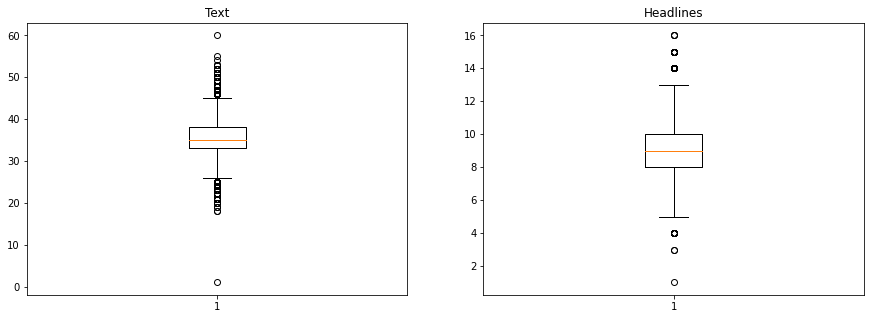

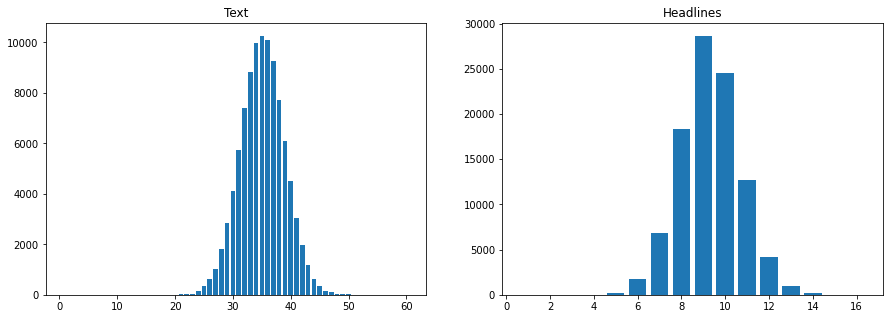

In [40]:
# 길이 분포 출력
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

len_text = [len(s.split()) for s in data['text']]
len_headlines = [len(s.split()) for s in data['headlines']]

print('text의 최소 길이 : {}'.format(np.min(len_text)))
print('text의 최대 길이 : {}'.format(np.max(len_text)))
print('text의 평균 길이 : {}'.format(np.mean(len_text)))
print('headlines의 최소 길이 : {}'.format(np.min(len_headlines)))
print('headlines의 최대 길이 : {}'.format(np.max(len_headlines)))
print('headlines의 평균 길이 : {}'.format(np.mean(len_headlines)))

len_text_counter = Counter(len_text)
len_headlines_counter = Counter(len_headlines)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.boxplot(len_text)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(len_headlines)
plt.title('Headlines')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(len_text_counter.keys(), len_text_counter.values())
plt.title('Text')
plt.subplot(1,2,2)
plt.bar(len_headlines_counter.keys(), len_headlines_counter.values())
plt.title('Headlines')
plt.show()

In [54]:
# 최대 길이 이용
max_text_len = 60
max_headlines_len = 16

In [55]:
# 데이터셋 준비
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

# 데이터 셔플
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# Train, Test 데이터 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

# code 7-6-11
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 19672
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


In [56]:
# 단어 빈도수 분석
def word_freq_analysis(tokenizer, threshold):
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [59]:
# 인덱스 사전 만들기
from tensorflow.keras.preprocessing.text import Tokenizer 

src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

word_freq_analysis(src_tokenizer, 6)

단어 집합(vocabulary)의 크기 : 69608
등장 빈도가 5번 이하인 희귀 단어의 수: 45589
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24019
단어 집합에서 희귀 단어의 비율: 65.49390874612114
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.08059771516363


In [60]:
# 사전 재생성
src_vocab = 25000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [61]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])
print(encoder_input_test[:3])

[[1264, 2008, 5260, 416, 158, 1858, 434, 249, 712, 42, 1174, 512, 615, 148, 222, 635, 158, 86, 1330, 6647, 20734, 3266, 199, 68, 2008, 5260, 475, 6648, 4513, 3974], [624, 16662, 55, 472, 416, 3822, 4664, 213, 8166, 49, 863, 253, 85, 5261, 154, 221, 10966, 3092, 1715, 5452, 619, 8283, 1716, 181, 615, 452, 227, 49, 6, 27, 472, 416], [5940, 413, 157, 58, 3600, 88, 53, 1346, 3, 13, 160, 13354, 132, 160, 1944, 242, 109, 1024, 17482, 162, 242, 4324, 1247, 3013, 365, 1768, 1514, 661, 9866, 413, 3057, 1346]]
[[26, 1249, 12713, 10204, 5383, 22, 57, 2524, 26, 47, 14, 1103, 829, 1, 1186, 2812, 42, 59, 1054, 1621, 10111, 874, 4, 76, 1, 9, 103, 3693, 336, 19108, 2257, 5852, 2621, 5383], [48, 112, 45, 70, 1988, 40, 2, 100, 372, 194, 2945, 1325, 2945, 536, 279, 182, 14, 6701, 49, 4797, 1055, 194, 358, 6, 3078, 156, 1356, 235, 27, 100, 976, 503, 1325, 48, 45, 72, 1325, 1988, 372, 559, 66, 874], [95, 2801, 285, 6846, 108, 999, 50, 1243, 6846, 75, 385, 5534, 1258, 93, 240, 1770, 731, 999, 23534, 29, 6, 

In [62]:
# 인덱스 사전 만들기 - 디코더 입력용
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

word_freq_analysis(tar_tokenizer, 6)

단어 집합(vocabulary)의 크기 : 30123
등장 빈도가 5번 이하인 희귀 단어의 수: 19694
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10429
단어 집합에서 희귀 단어의 비율: 65.37861434784053
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.637345745645472


In [63]:
# 사전 재생성
tar_vocab = 12500
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [64]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print(decoder_input_train[:3])
print(decoder_target_train[:3])

[[1, 208, 344, 2861, 6806, 399, 51, 165, 2991], [1, 208, 103, 62, 26, 132, 178, 16, 121, 200, 11586, 7, 3593], [1, 5893, 314, 85, 5, 698, 128, 105, 1029, 7, 166]]
[[208, 344, 2861, 6806, 399, 51, 165, 2991, 2], [208, 103, 62, 26, 132, 178, 16, 121, 200, 11586, 7, 3593, 2], [5893, 314, 85, 5, 698, 128, 105, 1029, 7, 166, 2]]


In [65]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [67]:
# pad 삽입
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input_train = pad_sequences(encoder_input_train, maxlen=max_text_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=max_text_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=max_headlines_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=max_headlines_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=max_headlines_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=max_headlines_len, padding='post')

In [69]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더
embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 디코더
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h1, state_c1])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      3200000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1600000     input_2[0][0]                    
______________________________________________________________________________________________

In [70]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
#attn_out = attn_layer([decoder_outputs, encoder_outputs])
attn_out = attn_layer([decoder_outputs, encoder_output1])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      3200000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1600000     input_2[0][0]                    
____________________________________________________________________________________________

In [71]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)


Epoch 1/50
308/308 [==============================] - 37s 103ms/step - loss: 4.4378 - val_loss: 4.0877
Epoch 2/50
308/308 [==============================] - 32s 105ms/step - loss: 3.9850 - val_loss: 3.7898
Epoch 3/50
308/308 [==============================] - 33s 108ms/step - loss: 3.6919 - val_loss: 3.5534
Epoch 4/50
308/308 [==============================] - 34s 111ms/step - loss: 3.4709 - val_loss: 3.4002
Epoch 5/50
308/308 [==============================] - 35s 114ms/step - loss: 3.3105 - val_loss: 3.2987
Epoch 6/50
308/308 [==============================] - 34s 112ms/step - loss: 3.1816 - val_loss: 3.2118
Epoch 7/50
308/308 [==============================] - 35s 112ms/step - loss: 3.0708 - val_loss: 3.1459
Epoch 8/50
308/308 [==============================] - 35s 112ms/step - loss: 2.9726 - val_loss: 3.0840
Epoch 9/50
308/308 [==============================] - 34s 112ms/step - loss: 2.8829 - val_loss: 3.0433
Epoch 10/50
308/308 [==============================] - 34s 112ms/step - l

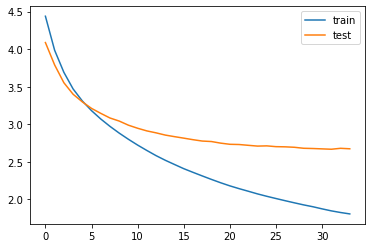

In [72]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [73]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [74]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


In [75]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    # [[YOUR CODE]]
    print(input_seq)
    temp=''
    for i in input_seq[1:]:
        if (i!=0):
            temp = temp + tar_index_to_word[i]+' '
    return temp


In [ ]:

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.


In [ ]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]
